# Getting started with FAIRiCube Hub
Authors: Maria Ricci, Manuel Löhnertz ([space4environment](https://space4environment.com/))

-----

In this demo you will see
- how to ingest raster data to SentinelHub
- how to request data from SentinelHub
- how to process a simple data cube and compute zonal statistics

The objective of this demo is to compute the share of Urban Atlas classes in a sample city.

We will use the following data:
- Urban Atlas 2018 ([original dataset](https://land.copernicus.eu/en/products/urban-atlas/urban-atlas-2018))
- city bounding boxes and boudary geometry (from database)
- population density ([FAIRiCube Catalog](https://catalog.fairicube.eu/population_density/))


### Load required packages and secrets

In [1]:
%matplotlib inline

# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import os
import shapely.geometry
import IPython.display

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocTile,
    DataCollection,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    Geometry
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## Ingest data to SentinelHub
### Dataset preparation
We will ingest the CLMS Urban Atlas Land Cover/Land Use 2018 dataset. 
Preprocessing steps:
- the [original dataset](https://land.copernicus.eu/en/products/urban-atlas/urban-atlas-2018) has been first rasterized to 10m resolution
- the raster Tiff file has been converted to Cloud Optimized GeoTiff format (COG) and tiled. See `pre-processing\gdal_tiff_to_tiled_cog.md` for further information
- the COG tiles have been saved in the UC1 s3 bucket
  
### Ingestion
To ingest the dataset in SentinelHub, we first create an empty collection, and then upload the tiles. This step can take some time, depending on the service availabilty. When a tile has finished uploading, its status changes to "INGESTED".

In [2]:
# Initialize SentinelHubBYOC class
byoc = SentinelHubBYOC(config=config)

new_collection = ByocCollection(name="UrbanAtlas2018_10m_raster_demo", s3_bucket="hub-fairicube0")
created_collection = byoc.create_collection(new_collection)
my_collection = byoc.get_collection(created_collection["id"])


# path to collection tiles
input_folder ="data/d002_urban_atlas"
tile_list = [
        "ua2018_mosaic_raster_10m_cog_5_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_1_(BAND).tif"
            ]

# ingest tiles
for tile in tile_list:
    path_link = input_folder+"/"+tile
    new_tile = ByocTile(path=path_link) 
    created_tile = byoc.create_tile(created_collection, new_tile)
    tile = byoc.get_tile(collection=created_collection["id"], tile=created_tile["id"])

Check the ingestion status

In [4]:
# check ingestion status
# tile ingestion can take a few minutes
collections_iterator = byoc.iter_collections("UrbanAtlas2018_10m_raster_demo")
my_collection = list(collections_iterator)[0]
print("Collection name:", my_collection["name"])
print("Collection id: ", my_collection["id"])
tiles = list(byoc.iter_tiles(my_collection))
for tile in tiles:
    print("Tile status: ", tile['status'])
    print("Tile created: ", tile['created'])

Collection name: UrbanAtlas2018_10m_raster_demo
Collection id:  9d062e18-de87-44f2-9b94-c4ba07c10637
Tile status:  WAITING
Tile created:  2024-03-12T09:26:11.590939Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:09.786042Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:11.491760Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:10.187165Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:09.987917Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:12.092371Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:10.288873Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:10.989393Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:10.690368Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:11.190508Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:10.792185Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:09.384662Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:11.394853Z
Tile status:  WAITING
Tile created:  2024-03-12T09:26:

In [4]:
# delete collection
# byoc.delete_collection(my_collection)

### Ingestion validation
Before starting to process, we check whether the ingested data corresponds to the original data. 
To check metadata and statistics, we can use the validation tool `pre-processing\quality_check.py` (still in development).
Quality assessment can be done by visually inspecting a small sample area.

## Use data from SentinelHub

Let's see all ingested collections. We can optionally print the datail of the tiles as well.

In [5]:
# list all ingested collections
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)
for collection in my_collections:
    
    print("Collection name:", collection["name"])
    print("Collection id: ", collection["id"])
#     tiles = list(byoc.iter_tiles(collection))
#     for tile in tiles:
#         print("Tile status: ", tile['status'])
#         print("Tile created: ", tile['created'])
#         print("Tile path: ", tile['path'])
#         if(tile['status'] == "FAILED"):
#             print("Ingestion failed error: ", tile['additionalData'])
    print("-------------------")

Collection name: TreeCoverDensity2018_10m_raster
Collection id:  3947b646-383c-4e91-aade-2f039bd6ba4b
-------------------
Collection name: UrbanAtlas2012_10m_raster
Collection id:  47ea75a0-875f-4ee9-ae78-b02be89d43d7
-------------------
Collection name: environmental_zones_1km
Collection id:  5b45916e-6704-4581-824f-4d713198731b
-------------------
Collection name: UrbanAtlas2018_10m_raster
Collection id:  78545a11-1e57-4ed0-a3ce-68c2e305216b
-------------------
Collection name: urban_audit_2021_city
Collection id:  7b4d761f-893b-43be-a4d6-4f37375318d3
-------------------
Collection name: UrbanAtlas2018_10m_raster_demo
Collection id:  9d062e18-de87-44f2-9b94-c4ba07c10637
-------------------
Collection name: urban_audit_2021_fua
Collection id:  c12e7be5-9f5e-441c-930f-2f274218e6d3
-------------------
Collection name: ImperviousnessDensity2018_10m_raster
Collection id:  c57f7668-2717-4529-93cc-5372bc96ebbe
-------------------
Collection name: nuts3_2021
Collection id:  d0a3f8c5-bf65-4bf

We are ready to build our first cube!

We can query data by a given bounding box, or define a geometry. Here we get the geometry and the bounding box from the UC1 database.

In [6]:
from src import db_connect
from sqlalchemy import text
import geopandas as gpd

home_dir = os.environ.get('HOME')
engine_postgresql = db_connect.create_engine(db_config = f"{home_dir}/uc1-urban-climate/database.ini")

with engine_postgresql.begin() as conn:
    query = text("""
              SELECT urau_code, urau_name, geometry
              FROM lut.l_city_urau2021
              """)
    gdf = gpd.read_postgis(query, conn, geom_col='geometry')

row = gdf[gdf.urau_name == 'Verona']
geometry_gdf = row.geometry # input argument
bbox_coords = geometry_gdf.bounds.minx, geometry_gdf.bounds.miny, geometry_gdf.bounds.maxx, geometry_gdf.bounds.maxy # input argument (or compute from geometry)

geometry = Geometry(geometry=geometry_gdf.item(), crs=CRS.WGS84) # define here your geometry
bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84) # define here your bounding box
bbox_size = bbox_to_dimensions(bbox, resolution=10)

Plot the bounding box and check that it is smaller than (2500, 2500) pixels

In [8]:
# plot bounding box
print(f"Image shape at {10} m resolution: {bbox_size} pixels") 
IPython.display.GeoJSON(shapely.geometry.box(*bbox.transform_bounds(CRS.WGS84)).__geo_interface__)

Image shape at 10 m resolution: (1883, 2186) pixels


<IPython.display.GeoJSON object>

Define the dimensions. In SentinelHub, each collection has a unique `collectionId`. We listed all collection´names and ids above.

In [9]:
# Urban atlas
# Collection name: UrbanAtlas2012_10m_raster
# Collection id:  47ea75a0-875f-4ee9-ae78-b02be89d43d7

collection_id_UA = "47ea75a0-875f-4ee9-ae78-b02be89d43d7"
collection_name_UA = "UrbanAtlas2018_10m_raster"
data_collection_UA = DataCollection.define_byoc(collection_id_UA, name=collection_name_UA)
data_collection_UA

The last ingredient for the SentinelHub request is the `evalscript`, which tells SH how to deliver the datacube. Here, we want to simply get the two collections in two separate layers. See later for a more complex `evalscript`.

In [13]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B1"],
    output: { 
        
        bands: 1,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}

function evaluatePixel(sample) {
  return [sample.B1];
}
"""
input_data = [
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster,
        )
    ]
request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        geometry=geometry, # comment out to get data within the bounding box
        size=bbox_size,
        config=config
    )

data = request.get_data()[0]

The request returns a numpy array.

In [14]:
# check dimensions and type
print(data.shape, type(data))

(2186, 1883) <class 'numpy.ndarray'>


In [17]:
data[1000:1500,1000:15000]

array([[12100, 12100, 12100, ...,     0,     0,     0],
       [12100, 12100, 12100, ...,     0,     0,     0],
       [12100, 12100, 12100, ...,     0,     0,     0],
       ...,
       [22000, 12220, 22000, ...,     0,     0,     0],
       [22000, 22000, 22000, ...,     0,     0,     0],
       [12220, 12220, 22000, ...,     0,     0,     0]], dtype=uint16)

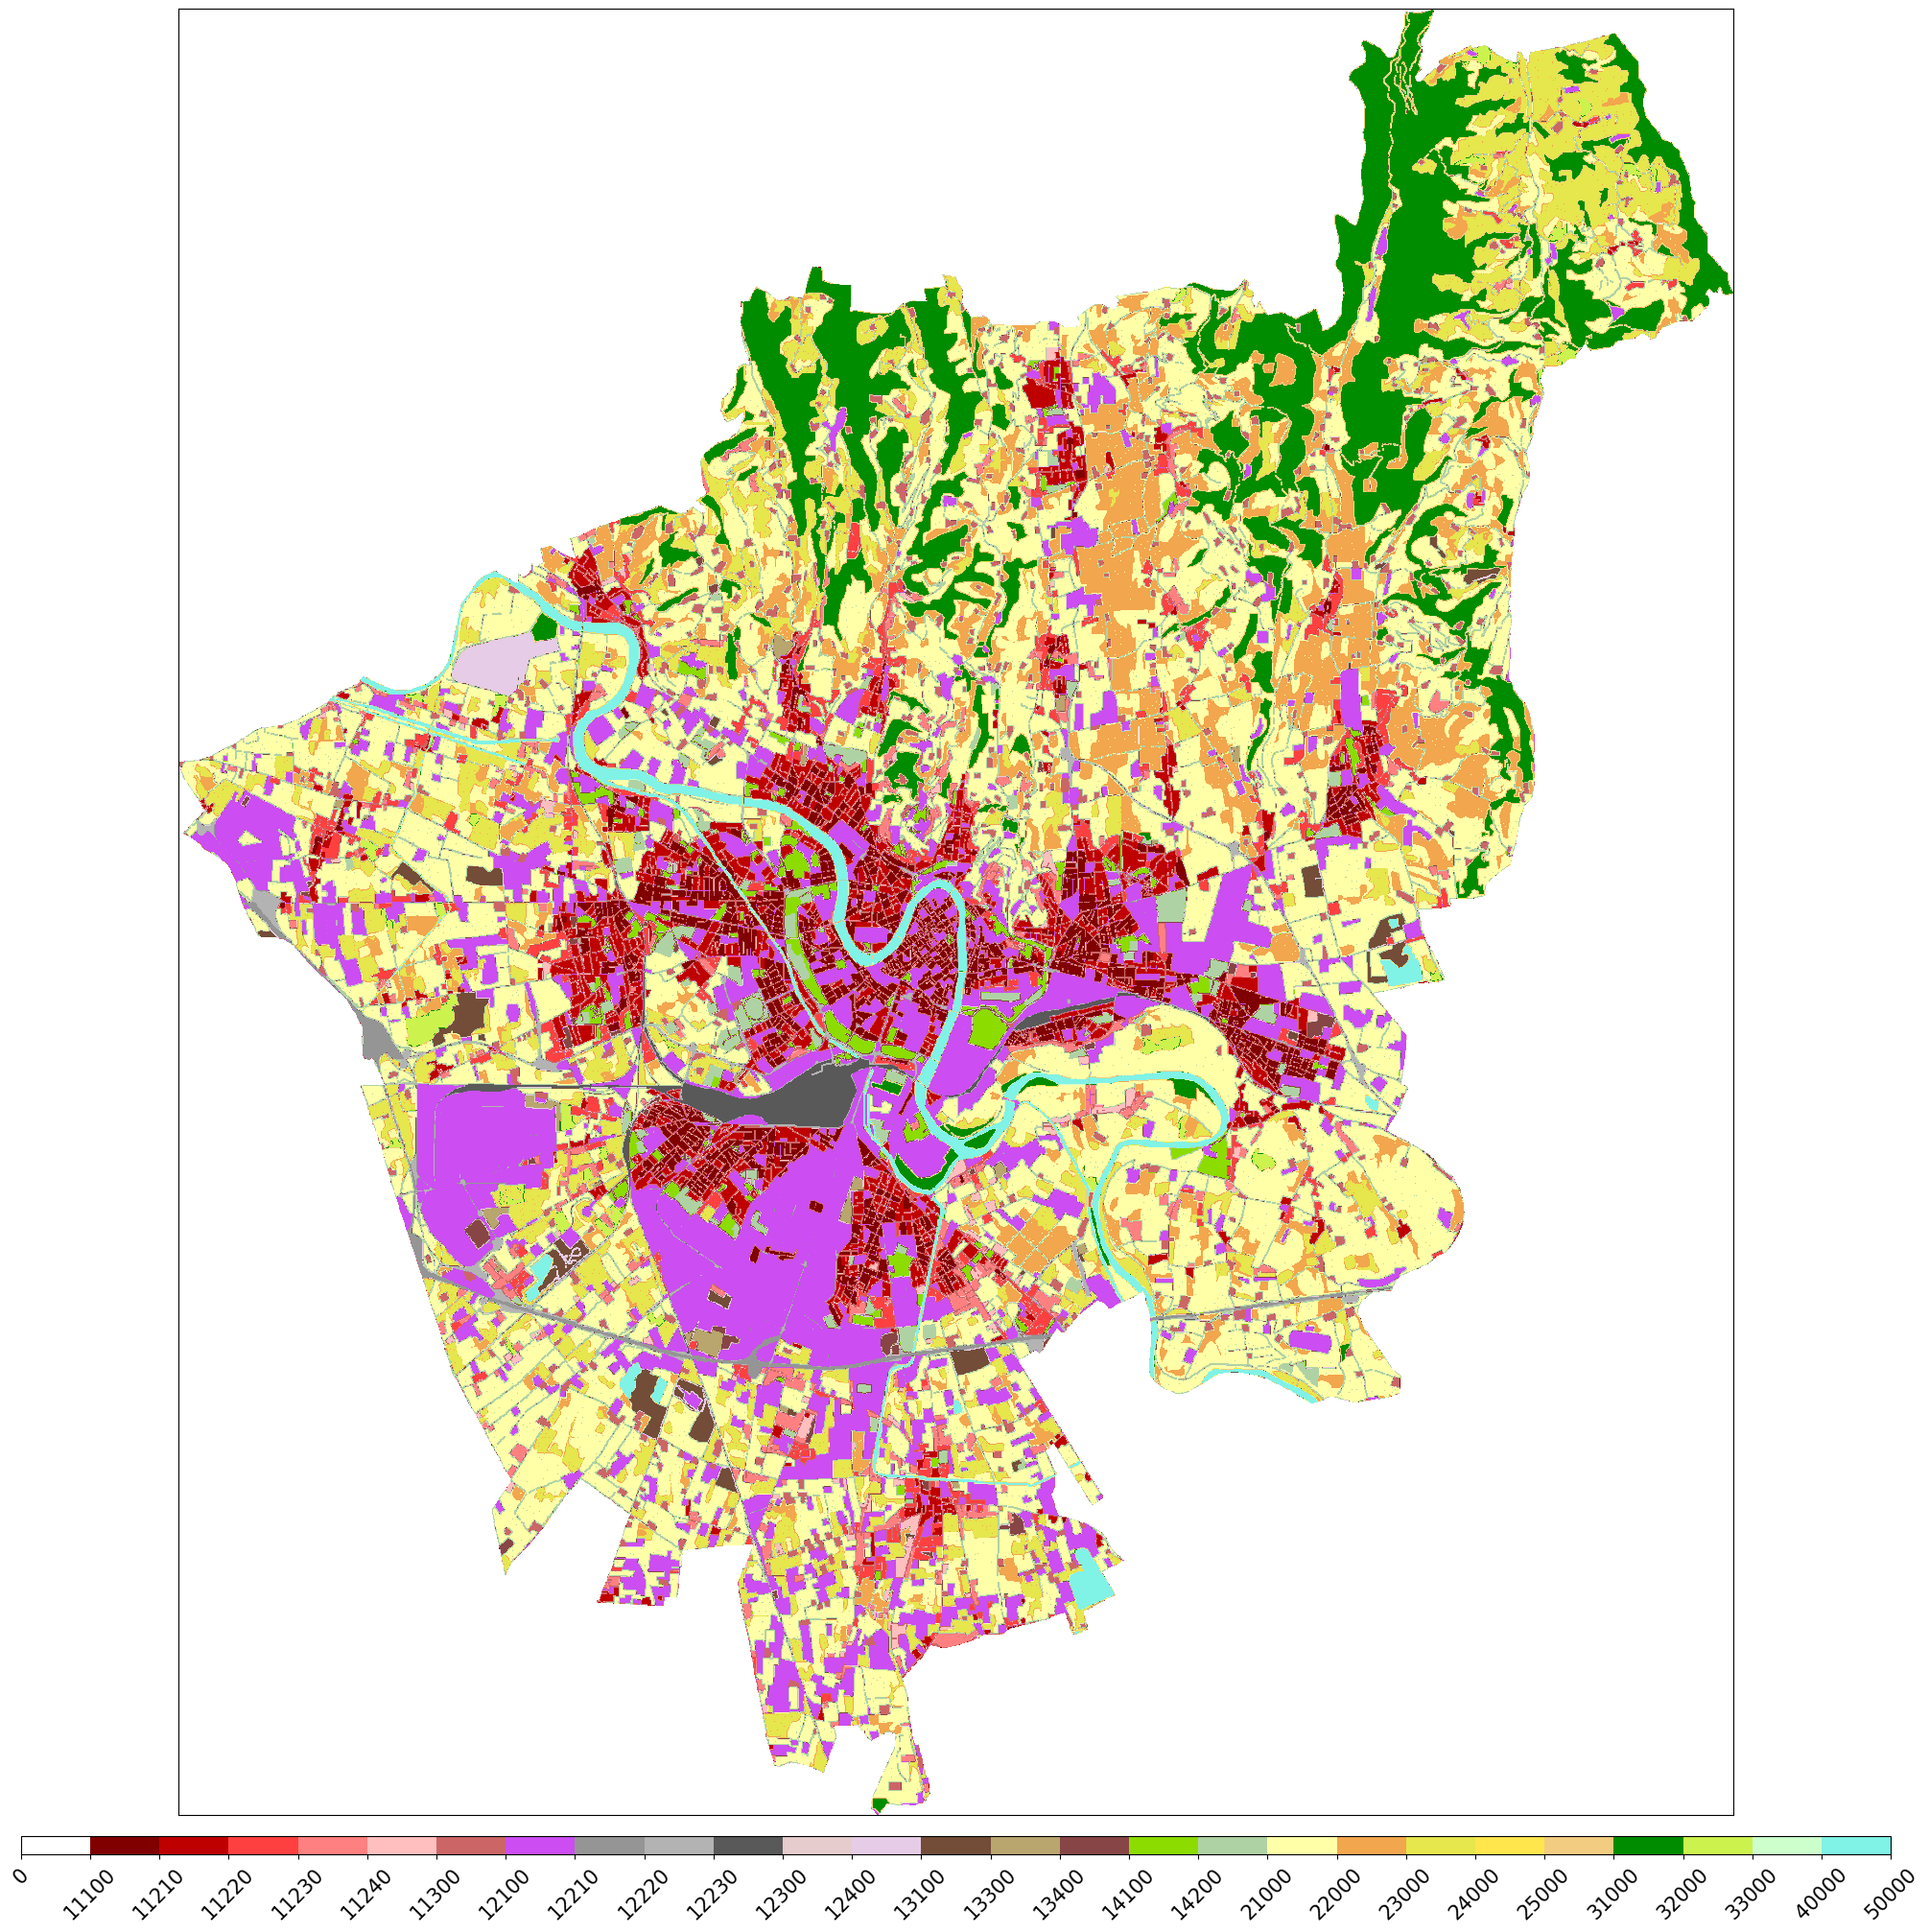

In [42]:
from src import utils
from matplotlib.colors import BoundaryNorm, ListedColormap
# define Urban Atlas colors
labels = [0, 11100, 11210, 11220, 11230, 11240, 11300, 12100, 12210, 12220, 12230, 12300, 12400, 13100, 13300, 13400, 
          14100, 14200, 21000, 22000, 23000, 24000, 25000, 31000, 32000, 33000, 40000, 50000]

ua_cmap = ListedColormap(
    ['#FFFFFF', '#800000', '#bf0000', '#ff4040', '#ff8080', '#ffbfbf', '#cc6666', '#cc4df2', '#959595', '#b3b3b3', 
     '#595959', '#e6cccc', '#e6cce6', '#734d37', '#b9a56e', '#874545', '#8cdc00', '#afd2a5', '#ffffa8', '#f2a64d', 
     '#e6e64d', '#ffe64d', '#f2cc80', '#008c00', '#ccf24d', '#ccffcc', '#a6a6ff', '#80f2e6'],
    name="ua_cmap")

ua_norm = BoundaryNorm(labels, ua_cmap.N)
fig, ax = plt.subplots(figsize=(20,20), layout='constrained')
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(data, cmap=ua_cmap, norm=ua_norm)
cb = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks(labels)
cb.ax.set_xticklabels(labels, rotation=45, fontsize=15)
plt.show();

## Compute zonal statistics
For each Urban Atlas class, we compute the number of pixels within the city. The result is a pandas DataFrame, which we can later save as .csv, or directly into the database.

In [18]:
df = pd.DataFrame(
    data={
    "urban_atlas_2018": pd.Series(data.ravel())
   })

table_cube_urban=df.groupby(['urban_atlas_2018']).size().reset_index().rename(columns={0:'area_ha'})
table_cube_urban

,urban_atlas_2018,count
0,0,2133599
1,11100,67128
2,11210,89705
3,11220,49560
4,11230,39969
5,11240,9708
6,11300,41344
7,12100,258030
8,12210,7540
9,12220,104015


## Data visualization
Once the harvested data is committed to the database, FAIRiCube data visualization tools can be used to inspect the results and compose dashboards and storymaps. The example below is a screenshot from the City Fact Sheet dashboard developed in FAIRiCube Grafana

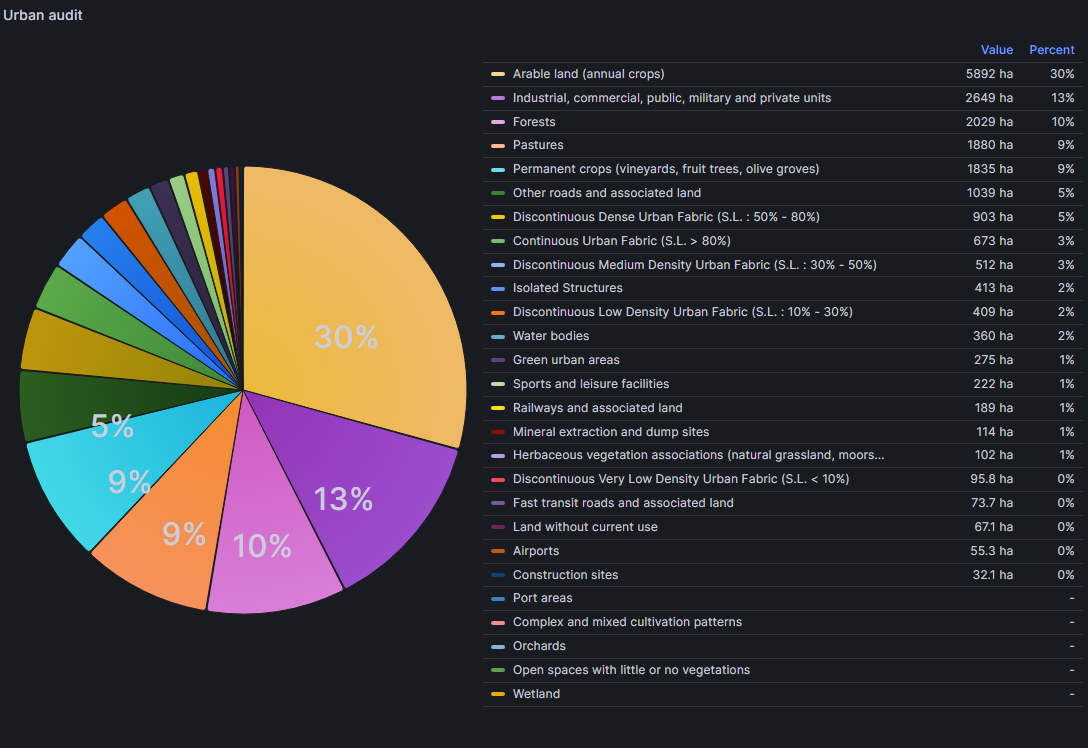

## Request data from EDC catalog

So far we have used our own collections. But it is possible to request other publicly available collections in the same way. 

We now combine ´two publicly available datasets:
- population density (FAIRiCube Catalog: https://catalog.fairicube.eu/population_density/)
- Copernicus DEM (FAIRiCube Catalog https://catalog.fairicube.eu/copernicus-dem/)

In the Catalog we find the SentinelHub CollectionId of `population_density`, while `copernicus_dem` is already registered as a named DataCollection

In [44]:
# population density
# https://collections.eurodatacube.com/population_density/
data_collection_pop = DataCollection.define_byoc("b468089b-2627-4787-b984-89c10434f6c6")
data_collection_dem = DataCollection.DEM_COPERNICUS_30

In this request we combine the two collections into one single dimension.

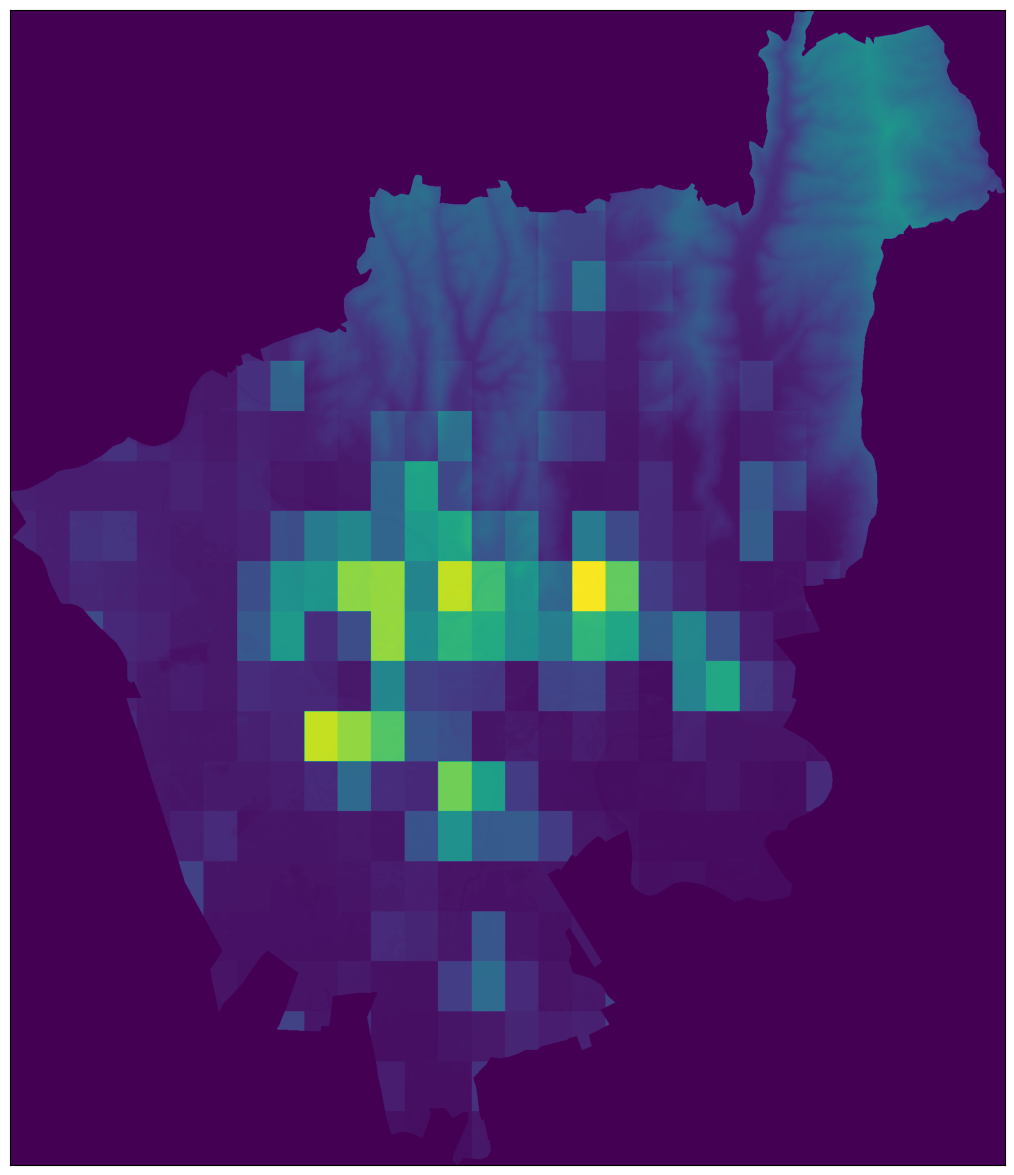

In [88]:
evalscript_combi = """
//VERSION=3
function setup() {
  return {
    input: [{
        datasource: "DEM",
        bands: ["DEM"]
      },
      {
        datasource: "pop",
        bands: ["populationDensity"]
      }
      ],
    output: [{
      bands: 1,
      sampleType: "UINT16" // raster format will be UINT16
    }]
  }
}


function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
    var dem = samples.DEM[0]
    var pop = samples.pop[0]
    return [pop.populationDensity+10* dem.DEM];
  
}
"""

request = SentinelHubRequest(
    evalscript=evalscript_combi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_collection_dem,
            identifier="DEM", 
        ),
        SentinelHubRequest.input_data(
            data_collection=data_collection_pop,
            identifier="pop", 
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    geometry=geometry,
    size=bbox_to_dimensions(bbox, resolution=10),
    config=config,
)

image = request.get_data()[0]

utils.plot_image(image)

In [89]:
import numpy as np
np.unique(image)

array([    0,   370,   373, ..., 13007, 13012, 13020], dtype=int32)